# Big Data Visualization

## Table of Contents:

+ [System Requirements](#syst)
+ [Python Libraries](#python)
+ [Assignment](#assg)
+ [Data Import](#import)
+ [Data Preparation](#prep)
+ [Part 1: Binning and Aggregation](#baa)
+ [Part 1: Pandas Dataframes](#pd)
+ [Part 1: Question](#q1)
+ [Part 1: Answer](#a1)
+ [Part 2: Datashader](#ds)
+ [Part 2: Question](#q2)
+ [Part 2: Answer](#a2)
+ [References](#ref)

# System Requirements <a class="anchor" id="syst"></a>

# Python Libraries <a class="anchor" id="python"></a>

In [69]:
import copy
import urllib
import json
import plotly # offline plotly
import datetime
import numpy as np 
import pandas as pd
import colorlover as cl
import datashader as ds
import datashader.glyphs
import plotly.plotly as py
import plotly.graph_objs as go
import datashader.transfer_functions as tf
from plotly import tools
from functools import partial
from datashader import reductions
from pyproj import Proj, transform
from datashader.core import bypixel
from IPython.display import GeoJSON
from bokeh.io import output_notebook, show # legend
from shapely.geometry import Point, Polygon, shape
from datashader.bokeh_ext import create_categorical_legend # legend
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # offline plotly

Plotly's Python library is free and open source. [Plotly Offline](https://plot.ly/python/offline/) brings interactive Plotly graphs to the offline (local) environment. Instead of saving the graphs to a server, your data and graphs will remain in your local system. 

In [70]:
init_notebook_mode(connected=True)
output_notebook()

Loading BokehJS ...

# Assignment  <a class="anchor" id="assg"></a>

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the `datashader` library (which possibly proves we'll never need to bin large data for visualization ever again.). To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's Department of City Planning. PLUTO contains data about every tax lot in New York City. PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the [data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), it'll come in handy for this assignment.

# Data Import  <a class="anchor" id="import"></a>

In [71]:
# Columns have mixed types. Specifying dtype or setting low_memory=False resolves error.
bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv', low_memory=False)
bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv', low_memory=False)
mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv', low_memory=False)
qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv', low_memory=False)
si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv', low_memory=False)
ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)
# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

# Data Preparation  <a class="anchor" id="prep"></a>

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader. You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [72]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc \
            +lat_1=40.66666666666666 \
            +lat_2=41.03333333333333 \
            +lat_0=40.16666666666666 \
            +lon_0=-74 \
            +x_0=300000 \
            +y_0=0 \
            +ellps=GRS80 \
            +datum=NAD83 \
            +to_meter=0.3048006096012192 \
            +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)
ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]
#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

# Part 1: Binning and Aggregation <a class="anchor" id="baa"></a>

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/). While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [73]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)
layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)
fig = go.Figure(data = [trace], layout = layout)
# py.iplot(fig, filename = 'ny-year-built')          # requires plotly license
plotly.offline.iplot(fig)                            # plot.ly Offline

Something looks off... You're going to have to deal with this imperfect data to answer this first question. But first: some notes on pandas. 

## Pandas Dataframes <a class="anchor" id="pd"></a>

Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed [and] help you guys through this homework:

  + [Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr.
  + [Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).
  + [Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.
  + Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.
  + [Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.
  + Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling"). Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

## Question <a class="anchor" id="q1"></a>

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn't yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

## Answer <a class="anchor" id="a1"></a>

### Resolve Year-Built Discrepancy

Metadata for the `YearBuilt` field from the [Data Dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1): **Field Name**: YEAR BUILT (YearBuilt); **Format**: Numeric - 4 digits (9999); **Data Source**: Department of Finance - RPAD Master File; **Description**: The year construction of the building was completed. Year Built comes from Department of Buildings Permits. Year Built is accurate for the decade but not necessarily for the specific year. Two outliers – 1910 & 1920. Structures built between 1800s and early 1900s usually have a Year Built date of either 1910 or 1920.

The metadata clearly identifies the underlying issue in the data: "Year Built is accurate for the decade but not necessarily for the specific year." To resolve the discrepancy, each value for year is rounded up to next decade.

In [74]:
ny_decades = ny[['YearBuilt', 'NumFloors', 'BBL']].copy() # Avoid case where changing df1 also changes df
ny_decades['YearBuilt'] = (np.ceil(ny_decades['YearBuilt'] / 10.0).astype(int) * 10) # round up to next decade
trace = go.Bar(
    x = ny_decades.groupby('YearBuilt').count()['BBL'].index,
    y = ny_decades.groupby('YearBuilt').count()['BBL']
)
layout = go.Layout(
    xaxis = dict(title = 'Decade Built'),
    yaxis = dict(title = 'Number of Lots Built')
)
fig = go.Figure(data = [trace], layout = layout)
plotly.offline.iplot(fig)

### Unusually Tall

The data contains buildings with partial floors. For example, 2.5 floors. These data points are transformed with the numpy ceiling function. Then each floor is binned into its rounded down tens value. When unstacking, the parameter `fill_value=0` improves EDA when looking at a DataFrame, but it clutters plots with unnecessary information when viewing tooltips (information displayed when hovering over the bars in the chart). A value of zero for a category is already implied by the absence of the category in the tooltips. The `hoverformat` parameter in the `layout` prevents the display of "undefined" for large values which plotly abbreviates by default.

In [75]:
height_dist = pd.DataFrame()
grouped = ny_decades.groupby(['YearBuilt', 'NumFloors'])
height_dist['Amount'] = grouped['NumFloors'].count()
subgrouped = height_dist.groupby(['YearBuilt'])['Amount']
height_dist['ECDF'] = subgrouped.cumsum() / subgrouped.sum() # ECDF
alpha = 0.01 # significance used to define unusual
height_dist['Unusual'] = height_dist['ECDF'] > (1 - alpha)
height_dist.groupby(['YearBuilt','Unusual']).filter(lambda x: (x['Unusual'] == True).all())
unusual = height_dist.groupby(['YearBuilt','Unusual']).sum()['Amount']
trace1 = go.Bar(
    x = unusual.unstack(level=-1)[False].index,
    y = unusual.unstack(level=-1)[False],
    name='Bottom 99%'
)
trace2 = go.Bar(
    x = unusual.unstack(level=-1)[True].index,
    y = unusual.unstack(level=-1)[True],
    name='Top 1%'
)
layout = go.Layout(
    xaxis = dict(title = 'Decade Built'),
    yaxis = dict(title = 'Height Distribution (Log Plot)',
                 showticklabels=False,
                 type = "log",
                 hoverformat = '.0f'),
    barmode = 'stack'
)
fig = go.Figure(data = [trace1, trace2], layout = layout)
plotly.offline.iplot(fig)

### Binned Height Per Year

The data contain buildings with partial floors. For example, 2.5 floors. These data points were transformed using the numpy ceiling function. Then each floor was binned into the rounding down tens value.

In [76]:
ny_binned = ny_decades.copy() # Avoid case where changing df1 also changes df
floors = ((np.ceil(ny_binned['NumFloors']) - 1) // 10 * 10 + 1).astype(int) # round
ny_binned['Binned'] = ['{0:03d} to {1:03d} Floors'.format(x, x+9) for x in floors] # bins
grouped = ny_binned.groupby(['YearBuilt', 'Binned', 'NumFloors'])
ny_floors = pd.DataFrame()
ny_floors['Amount'] = grouped['NumFloors'].count()
unstack = ny_floors.groupby(['YearBuilt','Binned']).sum()['Amount'].unstack(level=-1, fill_value=0)
unstack

Binned,001 to 010 Floors,011 to 020 Floors,021 to 030 Floors,031 to 040 Floors,041 to 050 Floors,051 to 060 Floors,061 to 070 Floors,071 to 080 Floors,081 to 090 Floors,101 to 110 Floors,111 to 120 Floors
YearBuilt,,,,,,,,,,,
1860,123,1,0,0,0,0,0,0,0,0,0
1870,107,1,0,0,0,0,0,0,0,0,0
1880,237,0,0,0,0,0,0,0,0,0,0
1890,609,3,0,0,0,0,0,0,0,0,0
1900,34534,80,7,0,0,0,0,0,0,0,0
1910,82617,359,14,1,1,0,1,0,0,0,0
1920,111394,496,36,5,2,0,1,0,0,0,0
1930,165430,961,126,33,14,6,1,0,0,0,0
1940,101385,151,17,11,6,1,3,0,1,1,0


Binning into every ten floors does not make sense. Relative to the bins for lower floors, the bins for buildings with 51 through 120 stories have very sparse data points. Combining those higher floor bins into one bin improves the visualization. When unstacking, the parameter `fill_value=0` improves EDA with a DataFrame, but it clutters the plot with unnecessary information when hovering over the bars in the chart because a value of zero for a category is already implied by the absence of the category when hovering over bars in the chart. Therefore, zeroes produced by `fill_value=0` and summing columns have been reverted to `NaN`.

In [77]:
unstack['051 to 120 Floors'] = unstack[unstack.columns[5:11]].sum(axis=1)
unstack = unstack.drop(columns=unstack.columns[5:11]).replace(0, np.nan)
unstack

Binned,001 to 010 Floors,011 to 020 Floors,021 to 030 Floors,031 to 040 Floors,041 to 050 Floors,051 to 120 Floors
YearBuilt,,,,,,
1860,123,1.0,NaN,NaN,NaN,NaN
1870,107,1.0,NaN,NaN,NaN,NaN
1880,237,NaN,NaN,NaN,NaN,NaN
1890,609,3.0,NaN,NaN,NaN,NaN
1900,34534,80.0,7.0,NaN,NaN,NaN
1910,82617,359.0,14.0,1.0,1.0,1.0
1920,111394,496.0,36.0,5.0,2.0,1.0
1930,165430,961.0,126.0,33.0,14.0,7.0
1940,101385,151.0,17.0,11.0,6.0,6.0


In [78]:
dataPanda = [] # pandas dataframe info for traces
for i in range(0, len(unstack.columns)):
    trace = go.Bar(
        x = unstack[unstack.columns[i]].index,
        y = unstack[unstack.columns[i]],
        name=unstack.columns[i]
    )
    dataPanda.append(trace) 
layout = go.Layout(
    xaxis = dict(title = 'Decade Built'),
    yaxis = dict(title = 'Number of Lots Built (Log Plot)',
                 showticklabels=False,
                 type = "log",
                 hoverformat = '.0f'),
    barmode = 'stack'
)
fig = dict(data=dataPanda, layout=layout)
plotly.offline.iplot(fig)

# Part 2: Datashader <a class="anchor" id="ds"></a>

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data. As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [79]:
yearbins = 200
floorbins = 200
yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))
xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))
data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]
# py.iplot(data, filename = 'datashader-2d-hist')    # requires plotly license
plotly.offline.iplot(data)                           # plot.ly Offline

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). Here is what the same plot would look like in datashader:

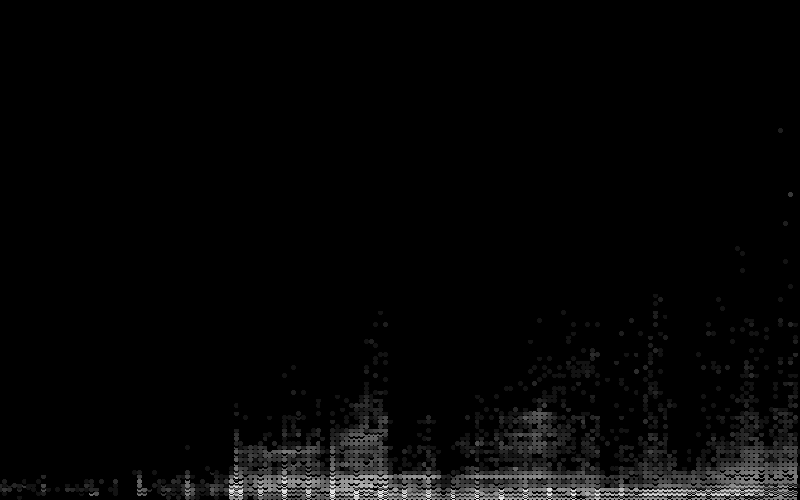

In [80]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions. Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

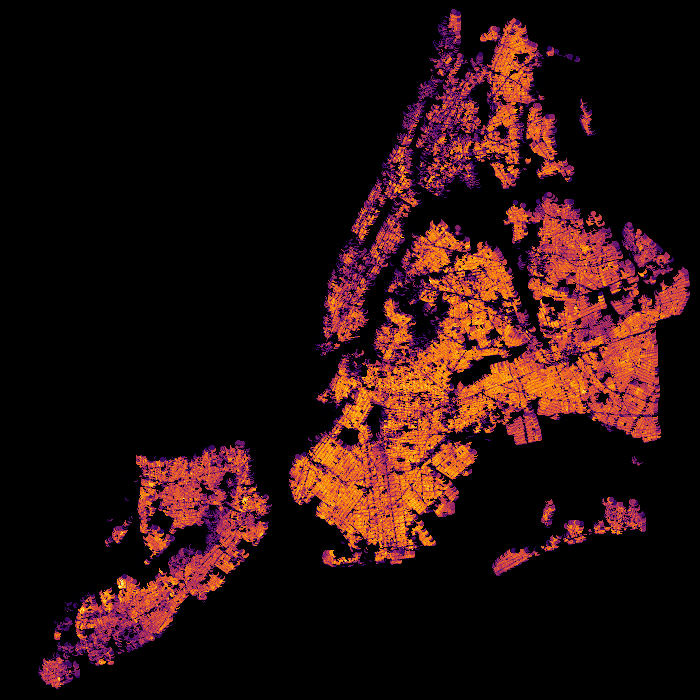

In [81]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes. Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

## Question <a class="anchor" id="q2"></a>

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

## Answer <a class="anchor" id="a2"></a>

From the [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/) site:
>The use of proportions, or rates, instead of raw counts is fundamental to creating a proper choropleth map... Choropleth maps should be normalized. The process of normalization accounts for differences in geographic areas by converting raw counts to rates or proportions. When social data are not normalized, they tend to reflect trends in where people live rather than interesting variations in the phenomena of interest... Most cartographers advise against maps with 9 or more classes. Thus it is recommended to keep things super simple when creating bivariate choropleth maps by not exceeding 3 classes in each variable. Create a third attribute that represents the combination of the two variables by its location in the bivariate color scheme.

In [82]:
ny_assmt = ny[['AssessTot', 'AssessLand','lon','lat']].copy() # Avoid case where changing df1 also changes df
ny_assmt['AssessBldg'] = ny_assmt['AssessTot'].sub(ny_assmt['AssessLand'], axis=0)
labels = [['A', 'B', 'C'], ['1', '2', '3']] # three classes in each variable
#['underbuilt', 'norm', 'overbuilt'] # underbuilt or overbuilt areas of the city
p = 100 / len(labels[0]) # underbuilt or overbuilt percentile bins
q = np.percentile(ny_assmt[['AssessLand', 'AssessBldg']], [p, 100 - p], axis=0) # breakpoints
ny_assmt['Var1_Class'] = pd.cut(ny_assmt['AssessLand'], [0, q[0][0], q[1][0], np.inf], right= False, labels=labels[0]) # binned
ny_assmt['Var2_Class'] = pd.cut(ny_assmt['AssessBldg'], [0, q[0][1], q[1][1], np.inf], right= False, labels=labels[1]) # binned
ny_assmt['Bi_Class'] = ny_assmt['Var1_Class'].astype(str) + ny_assmt['Var2_Class'].astype(str)
ny_assmt['Bi_Class'] = pd.Categorical(ny_assmt['Bi_Class'])
ny_assmt.head()

,AssessTot,AssessLand,lon,lat,AssessBldg,Var1_Class,Var2_Class,Bi_Class
1,10156950,834300,-73.987066,40.704619,9322650,C,3,C3
17,351000,129600,-73.989310,40.704109,221400,C,3,C3
20,236700,178200,-73.990608,40.704581,58500,C,3,C3
22,7785450,514350,-73.988008,40.704131,7271100,C,3,C3
23,40980600,972000,-73.987077,40.704101,40008600,C,3,C3


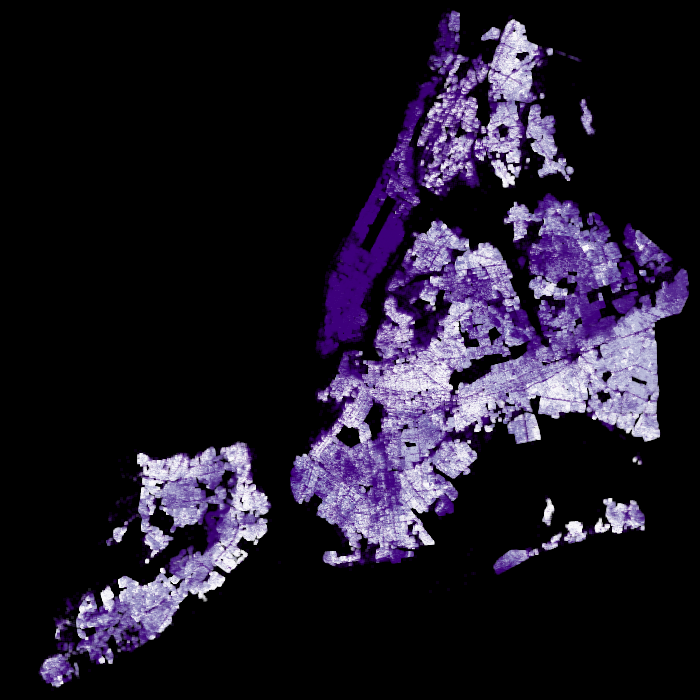

In [83]:
colors = {'A1': '#fcfbfd', 'A2': '#efedf5', 'A3': '#dadaeb', 
          'B1': '#bcbddc', 'B2': '#9e9ac8', 'B3': '#807dba', 
          'C1': '#6a51a3', 'C2': '#54278f', 'C3': '#3f007d'}
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny_assmt, 'lon', 'lat', ds.count_cat('Bi_Class'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'cloropleth')

In [84]:
show(create_categorical_legend(colors))

# References

https://plot.ly/python/axes/

https://plot.ly/ggplot2/geom_bar/

https://plot.ly/javascript/hover-events/

https://plot.ly/python/filled-area-plots/

https://plot.ly/python/text-and-annotations/

https://mkaz.tech/code/python-string-format-cookbook/

https://plot.ly/javascript/hover-text-and-formatting/

http://colorbrewer2.org/#type=sequential&scheme=Purples&n=9

https://pandas.pydata.org/pandas-docs/stable/categorical.html

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html

https://stackoverflow.com/questions/26454649/python-round-up-to-the-nearest-ten

https://stackoverflow.com/questions/37037564/using-groupby-group-names-in-function

https://stackoverflow.com/questions/27488080/python-pandas-filter-rows-after-groupby

https://community.plot.ly/t/how-to-add-100-traces-in-a-plot-without-using-an-api-call-each-time/2885

https://stackoverflow.com/questions/15360925/how-to-get-the-first-column-of-a-pandas-dataframe-as-a-series